# 机器学习工程师纳米学位
## 模型评价与验证
## 项目 1: 预测波士顿房价



项目本身很简单： 利用马萨诸塞州波士顿郊区的房屋信息数据训练和测试一个模型，并对模型的性能和预测能力进行测试。

主要通过项目掌握：

1. 如何对回归模型评分？ R2系数及其意义
2. 给定数据，如何拆分数据，对模型进行训练、评估？ 为什么
3. 学习曲线、复杂度曲线、bias、variance、欠拟合、过拟合等概念
4. 训练模型 = 找出参数（比如线性回归中的weights和intercept）。此外还有一些hyperparameter，即模型算法参数。如何找出最优的模型？ 网格搜索
5. 调参训练之后，找到最优模型，如何评估此模型？ 原则： 不能用模型训练时见过的数据评估模型

In [12]:
# 载入此项目所需要的库
import numpy as np
import pandas as pd
import visuals as vs # Supplementary code

# 检查你的Python版本
from sys import version_info
if version_info.major != 2 and version_info.minor != 7:
    raise Exception('请使用Python 2.7来完成此项目')
    
# 让结果在notebook中显示
%matplotlib inline
np.set_printoptions(precision=4, suppress=True)

# 载入波士顿房屋的数据集
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# 完成
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))
print(data.shape)
print(data.head())
prices.describe()

Boston housing dataset has 489 data points with 4 variables each.
(489, 4)
      RM  LSTAT  PTRATIO      MEDV
0  6.575   4.98     15.3  504000.0
1  6.421   9.14     17.8  453600.0
2  7.185   4.03     17.8  728700.0
3  6.998   2.94     18.7  701400.0
4  7.147   5.33     18.7  760200.0


count    4.8900e+02
mean     4.5434e+05
std      1.6534e+05
min      1.0500e+05
25%      3.5070e+05
50%      4.3890e+05
75%      5.1870e+05
max      1.0248e+06
Name: MEDV, dtype: float64

- RM：房间数应当与房价正相关， 房间数越多，面积越大，房价应该越高
- LSTAT：低收入者数量与房价负相关， 低收入者越多，说明可承担房价也较低，房价相对来说也应该较低
- PTRATIO： 学生/老师比如果较大，说明当地教育质量较低，房价相对较低。 负相关



In [14]:
# 拆分数据为训练集、测试集
from sklearn.model_selection import train_test_split

def generate_train_and_test(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=1)
    
X_train, X_test, y_train, y_test = generate_train_and_test(features, prices)

In [18]:
# 评分标准 R2
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):    
    score = r2_score(y_true, y_predict)
    return score

def performance_metric(y_true, y_predict):
    var = np.var(y_true)
    res = np.sum(np.subtract(y_true, y_predict)**2)
    score = 1.0 - res / (var * len(y_true))
    return score

### 学习曲线
下方区域内的代码会输出四幅图像，它们是一个决策树模型在不同最大深度下的表现。每一条曲线都直观得显示了随着**训练数据量**的增加，模型学习曲线的在训练集评分和验证集评分的变化，评分使用决定系数R<sup>2</sup>。曲线的阴影区域代表的是该曲线的不确定性（用标准差衡量）。

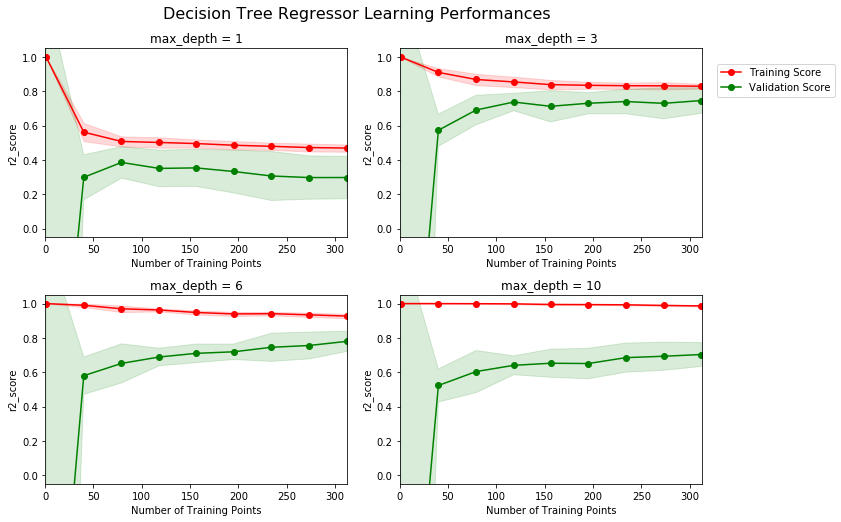

In [21]:
import matplotlib.pyplot as pl
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit, train_test_split

def ModelLearning(X, y):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and validation scores for each model are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = pl.figure(figsize=(10,7))

    # Create three different models based on max_depth
    for k, depth in enumerate([1,3,6,10]):
        
        # Create a Decision tree regressor at max_depth = depth
        regressor = DecisionTreeRegressor(max_depth = depth)

        # Calculate the training and testing scores
        sizes, train_scores, valid_scores = learning_curve(regressor, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = 'r2')
        
        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        valid_std = np.std(valid_scores, axis = 1)
        valid_mean = np.mean(valid_scores, axis = 1)

        # Subplot the learning curve 
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, valid_mean, 'o-', color = 'g', label = 'Validation Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, valid_mean - valid_std, \
            valid_mean + valid_std, alpha = 0.15, color = 'g')
        
        # Labels
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('r2_score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])
    
    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()
    
vs.ModelLearning(X_train, y_train)

第三幅图， max_depth = 6， 随着训练数据量的增加，训练集曲线和验证集曲线都会收敛到特定的值。 如果有更多的训练数据，可以提升模型的表现。

第四幅图过拟合了：训练集表现很好，但是测试集表现很差。需要使用更多的训练集数据才能明显提升模型的泛化能力。

>传统的机器学习算法（又被称为基于统计的机器学习）在数据量达到一定程度后，更多的数据无法提升模型的表现。深度学习的一个优势就是它可以把大量的数据利用起来，提升学习表现。


### 复杂度曲线
下列代码内的区域会输出一幅图像，它展示了一个已经经过训练和验证的决策树模型在不同最大深度条件下的表现。这个图形将包含两条曲线，一个是训练集的变化，一个是验证集的变化。跟**学习曲线**相似，阴影区域代表该曲线的不确定性，模型训练和测试部分的评分都用的 `performance_metric` 函数。


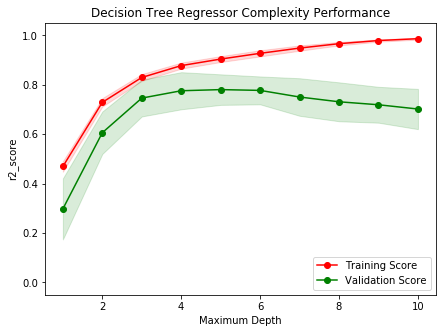

In [22]:
def ModelComplexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and validation errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, valid_scores = validation_curve(DecisionTreeRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    # Plot the validation curve
    pl.figure(figsize=(7, 5))
    pl.title('Decision Tree Regressor Complexity Performance')
    pl.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    pl.plot(max_depth, valid_mean, 'o-', color = 'g', label = 'Validation Score')
    pl.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    pl.fill_between(max_depth, valid_mean - valid_std, \
        valid_mean + valid_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    pl.legend(loc = 'lower right')
    pl.xlabel('Maximum Depth')
    pl.ylabel('r2_score')
    pl.ylim([-0.05,1.05])
    pl.show()

vs.ModelComplexity(X_train, y_train)

当模拟以最大深度1训练时，模型预测出现很大的偏差（bias）； 模型以最大深度10训练时，模型出现很大的方差（variance）

- High bias：无论训练集合还是测试集数据的评分都很低，模型表现不好，对数据并不敏感，bias较大。
- High variance： 模型对训练集合的评分很高，但是对测试数据的评分较差，属于过拟合，泛化能力较弱，对新数据表现不好，variance较大。


最大深度为4时，模型能够最好的对未见过的数据进行预测。因为
1. 此时测试集合评分达到最高值
2. 训练集合与测试集合评分最接近
3. 模型足够简单，且从学习曲线可以看出，可以很快收敛。

---
###  选择最优参数：网格搜索（Grid Search）及交叉验证（Cross Validation）

事先为每个参数设定一组值，然后穷举各种参数组合，训练模型，找到评分最好的模型使用的参数，这种方法就是网格搜索。


K折交叉验证：将训练数据分成K组（一般是均分，默认是顺序切分），将每个子集数据分别做一次验证集（CV），其余的K-1组子集数据作为训练集，这样会得到K个模型及各自的验证集评分。 K个模型的验证集评分的平均值即为模型的最终评分。

使用cross-validation一般能很好估计模型的泛化能力，即对测试集合的预测评分。GridSearchCV结合交叉验证，遍历各种参数组合，找出评分最高的模型及其参数组合，作为最优模型和最佳参数组合。

GridSearchCV 的 `cv_results_` 属性会列出各种参数组合以及训练组、交叉验证组的评分和平均评分。可以观察出模型随参数的变化（欠拟合、过拟合）


网格搜索时如果不使用交叉验证会有什么问题？

网格搜索时如果不使用交叉验证，比如只将训练数据划分为8:2的训练集和验证集，在训练集上训练， 验证集上打分，选出表现最好的一组参数。但这样做只用到了训练数据的80%，并没有充分利用所有训练数据，会有些偏差。使用K-Fold交叉验证或者其他交叉验证方式，可以充分利用所有训练数据，准确评估模型性能。

> K折交叉验证避免了因为数据集划分的偶然性造成的评分偏高或偏低的问题。 对于每一组参数对应的模型，通过使用不同的训练集和验证集训练然后取K次评分的平均来得到最终成绩来保证评分的客观和准确，从而准确定位到给出参数中的最优参数。

validation的意思是指分出训练集的一部分作为验证集； cross有rotation的意思（之前我的理解有误）。使用cross-validation既可以充分利用训练集，还可以准确评估模型的泛化能力。


In [32]:
# 使用sklearn 自带函数实现网格搜索

from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ 基于输入数据 [X,y]，利于网格搜索找到最优的决策树模型"""
    
    cross_validator = KFold()
    
    regressor = DecisionTreeRegressor(random_state=0)

    params = {'max_depth': np.arange(1,11)}

    scoring_fnc = make_scorer(performance_metric)

    grid = GridSearchCV(regressor, params, scoring_fnc, cv=cross_validator)

    # 基于输入数据 [X,y]，进行网格搜索
    grid = grid.fit(X, y)
    
    # print(pd.DataFrame(grid.cv_results_))

    # 返回网格搜索后的最优模型
    return grid.best_estimator_

# fit_model(X_train, y_train)

In [30]:
# 不使用 DecisionTreeRegressor 以外的任何 sklearn 库，手动实现交叉验证，网格搜索

def cv_split(X, y, n_splits=3):
    n_samples = len(X)
    fold_sizes = (n_samples // n_splits) * np.ones(n_splits, dtype=np.int)
    fold_sizes[:n_samples % n_splits] += 1
    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_mask = np.zeros(n_samples, dtype=np.bool)
        test_mask[start:stop] = True
        train_mask = np.logical_not(test_mask)
        yield X[train_mask], y[train_mask], X[test_mask], y[test_mask]
        current = stop
    
def cross_val_score(estimator, X, y, scoring=performance_metric, cv=3):
    """ 返回每组交叉验证的模型分数的数组 """
    scores = []
    for X_train, y_train, X_test, y_test in cv_split(X, y, n_splits=cv):
        estimator.fit(X_train, y_train)
        test_score = scoring(y_test, estimator.predict(X_test))
        scores.append(test_score)
    return scores

def fit_model(X, y):
    """ 基于输入数据 [X,y]，利于网格搜索找到最优的决策树模型"""
    
    #最优交叉验证分数对应的最优模型
    best_estimator = None
    best_score = 0
    for max_depth in range(1, 11):
        estimator = DecisionTreeRegressor(max_depth=max_depth, random_state=0)
        scores = cross_val_score(estimator, X, y)
        if np.average(scores) > best_score:
            best_estimator = estimator
            best_score = np.average(scores)
        # print(scores)
            
    return best_estimator

# fit_model(X_train, y_train)


In [33]:
# 基于训练数据，获得最优模型
optimal_reg = fit_model(X_train, y_train)

# 输出最优模型的 'max_depth' 参数
print("Parameter 'max_depth' is {} for the optimal model.".format(optimal_reg.get_params()['max_depth']))

Parameter 'max_depth' is 4 for the optimal model.


### 预测
想像你是一个在波士顿地区的房屋经纪人，并期待使用此模型以帮助你的客户评估他们想出售的房屋。你已经从你的三个客户收集到以下的资讯:

| 特征 | 客戶 1 | 客戶 2 | 客戶 3 |
| :---: | :---: | :---: | :---: |
| 房屋内房间总数 | 5 间房间 | 4 间房间 | 8 间房间 |
| 社区贫困指数（％被认为是贫困阶层） | 17% | 32% | 3% |
| 邻近学校的学生-老师比例 | 15：1 | 22：1 | 12：1 |


In [34]:
# 生成三个客户的数据
client_data = [[5, 17, 15], # 客户 1
               [4, 32, 22], # 客户 2
               [8, 3, 12]]  # 客户 3

# RM  LSTAT  PTRATIO 
# print(np.min(data['PTRATIO']))
# 进行预测
predicted_price = optimal_reg.predict(client_data)
for i, price in enumerate(predicted_price):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $411,417.39
Predicted selling price for Client 2's home: $230,828.57
Predicted selling price for Client 3's home: $937,230.00


### 在测试集上评估最优模型

In [35]:

y_predict = optimal_reg.predict(X_test)
r2 = performance_metric(y_test, y_predict)

print ("Optimal model has R^2 score {:,.2f} on test data".format(r2))

Optimal model has R^2 score 0.78 on test data
